<a href="https://colab.research.google.com/github/Keishin315/Keishin315/blob/main/store_sales_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook provides a recipe for using Kaggle API with Colab

In [1]:
!pip install kaggle

# API Credentials

To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. Then go to the 'Account' tab of your user profile (https://www.kaggle.com/<username>/account) and select 'Create API Token'. This will trigger the download of kaggle.json, a file containing your API credentials. 

Place this file on your Google Drive anywhere.

With the next snippet you download your credentials to Colab and you can start using Kaggle API

In [ ]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

KeyboardInterrupt: ignored

In [2]:
import csv
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [4]:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         85           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes         76           False  
store-sales-time-series-forecasting            2030-06-30 23:59:00  Getting Started  Knowledge        796           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        139           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       1562           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      14329            True  
house-pr

In [5]:
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c store-sales-time-series-forecasting

  0% 0.00/21.8k [00:00<?, ?B/s]
100% 21.8k/21.8k [00:00<00:00, 8.71MB/s]
  0% 0.00/1.35k [00:00<?, ?B/s]
100% 1.35k/1.35k [00:00<00:00, 1.09MB/s]
  0% 0.00/360k [00:00<?, ?B/s]
100% 360k/360k [00:00<00:00, 50.1MB/s]
  0% 0.00/998k [00:00<?, ?B/s]
100% 998k/998k [00:00<00:00, 66.0MB/s]
 82% 17.0M/20.8M [00:01<00:00, 13.6MB/s]
100% 20.8M/20.8M [00:01<00:00, 17.2MB/s]
  0% 0.00/20.1k [00:00<?, ?B/s]
100% 20.1k/20.1k [00:00<00:00, 17.6MB/s]
  0% 0.00/334k [00:00<?, ?B/s]
100% 334k/334k [00:00<00:00, 47.2MB/s]


以下分析

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

In [8]:
traincsv = pd.read_csv('train.csv.zip')

In [9]:
traincsv.date = pd.to_datetime(traincsv["date"])

In [10]:
traincsv = traincsv.sort_values(['date','store_nbr','family'])

In [11]:
train = traincsv.set_index('date').drop('id',axis = 1).copy()
train

,store_nbr,family,sales,onpromotion
date,,,,
2013-01-01,1,AUTOMOTIVE,0.000,0
2013-01-01,1,BABY CARE,0.000,0
2013-01-01,1,BEAUTY,0.000,0
2013-01-01,1,BEVERAGES,0.000,0
2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...
2017-08-15,54,POULTRY,59.619,0
2017-08-15,54,PREPARED FOODS,94.000,0
2017-08-15,54,PRODUCE,915.371,76


In [12]:
trainY = train.sales
train = train.drop('sales',axis = 1)

In [13]:
train = np.array(train)
trainY = np.array(trainY)

In [14]:
#datasetを作る

def make_dataset(data,dataY):
  datasetX = []
  yset = []
  max_length = len(data)
  for i in range(5346,max_length-54*33,54*33):
    datasetX.append(data[i-5346:i,2])
    yset.append(dataY[i:i+54*33])

  return datasetX,yset

  

In [15]:
trainX,trainY = make_dataset(train,trainY)

In [16]:
#scaling
scaler = MinMaxScaler()  # データを0～1の範囲にスケールするための関数。
scaler.fit(trainX)  # スケーリングに使用する最小／最大値を計算する。
train = scaler.transform(trainX)  # Xをを0～1の範囲にスケーリングする。

scaler1 = MinMaxScaler()  # データを0～1の範囲にスケールするための関数。
scaler1.fit(trainY)  # スケーリングに使用する最小／最大値を計算する。
trainY = scaler1.transform(trainY)  # Yをを0～1の範囲にスケーリングする。

In [17]:
trainY = np.array(trainY)
trainX = np.array(trainX)
trainX = np.reshape(trainX,(trainX.shape[0],1,trainX.shape[1]))
print(trainY.shape,trainX.shape)

(1680, 1782) (1680, 1, 5346)


In [20]:
train_X = np.asarray(train_X).astype(np.float32)
train_Y = np.asarray(train_Y).astype(np.float32)

In [19]:
# train, testデータを定義
train_X = trainX[:1000, :, :]
test_X = trainX[1000:, :, :]
train_Y = trainY[:1000, :]
test_Y = trainY[1000:, :]

In [21]:
test_X = np.asarray(test_X).astype(np.float32)
test_Y = np.asarray(test_Y).astype(np.float32)

In [22]:
train_Y

array([[0.15789473, 0.        , 0.25      , ..., 0.        , 0.        ,
        0.08333334],
       [0.2631579 , 0.        , 0.25      , ..., 0.        , 0.        ,
        0.04166667],
       [0.10526316, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.16666667, ..., 0.24817581, 0.        ,
        0.        ],
       [0.05263158, 0.        , 0.25      , ..., 0.209476  , 0.        ,
        0.375     ],
       [0.21052632, 0.        , 0.33333334, ..., 0.25854528, 0.        ,
        0.20833333]], dtype=float32)

In [23]:
model = Sequential()
model.add(LSTM(50, input_shape=(1,5346)))
model.add(Dense(1782))
model.compile(loss='mean_squared_error', optimizer='adam')
hist = model.fit(train_X,train_Y,epochs=20, batch_size=1, verbose=2)

Epoch 1/20
1000/1000 - 8s - loss: 0.0132 - 8s/epoch - 8ms/step
Epoch 2/20
1000/1000 - 4s - loss: 0.0088 - 4s/epoch - 4ms/step
Epoch 3/20
1000/1000 - 4s - loss: 0.0086 - 4s/epoch - 4ms/step
Epoch 4/20
1000/1000 - 3s - loss: 0.0084 - 3s/epoch - 3ms/step
Epoch 5/20
1000/1000 - 3s - loss: 0.0083 - 3s/epoch - 3ms/step
Epoch 6/20
1000/1000 - 3s - loss: 0.0082 - 3s/epoch - 3ms/step
Epoch 7/20
1000/1000 - 4s - loss: 0.0082 - 4s/epoch - 4ms/step
Epoch 8/20
1000/1000 - 3s - loss: 0.0081 - 3s/epoch - 3ms/step
Epoch 9/20
1000/1000 - 3s - loss: 0.0080 - 3s/epoch - 3ms/step
Epoch 10/20
1000/1000 - 3s - loss: 0.0080 - 3s/epoch - 3ms/step
Epoch 11/20
1000/1000 - 3s - loss: 0.0080 - 3s/epoch - 3ms/step
Epoch 12/20
1000/1000 - 3s - loss: 0.0080 - 3s/epoch - 3ms/step
Epoch 13/20
1000/1000 - 4s - loss: 0.0079 - 4s/epoch - 4ms/step
Epoch 14/20
1000/1000 - 3s - loss: 0.0079 - 3s/epoch - 3ms/step
Epoch 15/20
1000/1000 - 3s - loss: 0.0079 - 3s/epoch - 3ms/step
Epoch 16/20
1000/1000 - 3s - loss: 0.0079 - 3s/ep

In [24]:
Predict = model.predict(test_X)

In [25]:
Predict.shape

(680, 1782)

In [26]:
#scaleを元に戻す
train_Y = scaler1.inverse_transform(train_Y)
train_Y = pd.DataFrame(train_Y)


test_Y = scaler1.inverse_transform(test_Y)
test_Y = pd.DataFrame(test_Y)




In [27]:
Predict = scaler1.inverse_transform(Predict)
Predict = pd.DataFrame(Predict)


In [28]:
Predict

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1742,1743,1744,1745,1746,1747,1748,1749,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763,1764,1765,1766,1767,1768,1769,1770,1771,1772,1773,1774,1775,1776,1777,1778,1779,1780,1781
0,3.404082,0.007389,3.175499,2197.084961,0.001157,365.339935,9.149660,615.613708,747.156616,138.724411,171.268097,142.727417,2306.685547,25.524965,2.699072,11.466297,10.595510,0.391331,179.944580,19.392418,8.971756,7.322301,172.407516,1.304317,304.614319,167.255325,7.070538,6.677969,313.970886,96.282059,2269.782715,0.533586,28.056507,7.363591,-0.000356,8.096240,3665.579834,-0.001133,676.177246,12.224418,...,1.178621,5.636192,222.638885,66.238548,1510.989624,0.938877,5.786588,7.755096,0.405083,0.282261,1993.781128,-0.004259,283.828400,5.617423,1468.607910,228.976944,235.895264,103.276871,55.486496,3280.947510,12.472815,0.803564,24.174141,14.341930,0.295455,229.205017,0.001010,0.008952,8.679973,42.119869,0.255216,61.170475,226.549026,0.291272,2.222749,74.410645,64.240860,558.629822,0.000787,0.895049
1,0.769978,0.010009,1.431513,1016.578125,-0.043655,141.160675,2.760537,276.338867,349.553864,78.416115,72.915787,89.179214,1011.058350,4.549982,1.567783,5.754820,9.537512,0.107559,104.761635,8.059249,4.375337,2.655731,0.591508,1.008243,154.810806,84.793159,4.200466,2.236558,123.267265,52.943592,1185.642090,0.272626,13.214296,6.960372,-0.019465,10.288421,4262.937012,0.021879,882.308167,8.057634,...,1.794413,8.287964,267.219116,97.568153,1951.183960,1.268034,7.925442,10.161186,0.454574,0.916719,2484.200928,-0.003537,393.949524,4.989523,2073.901123,324.056091,324.147125,123.471298,43.792850,4182.806641,13.960300,1.209065,23.877714,23.698139,0.151619,380.283508,-0.001683,0.009579,6.944691,-5.421474,0.047096,72.527092,329.173004,-0.014680,2.945698,62.735882,89.880478,660.842773,-0.148110,2.226529
2,3.621934,0.002620,2.578624,2015.348633,-0.025175,383.598969,8.077986,720.024780,732.200928,145.757202,152.784622,130.446991,2421.078125,33.317825,2.478692,18.078840,11.501969,0.490781,158.528046,20.194281,8.770413,8.926812,83.954643,1.092269,374.441376,153.736710,6.781229,7.527555,362.526154,91.448036,2162.281982,0.488705,25.718128,4.733794,-0.003981,5.777971,2643.239258,0.016846,522.805176,8.236711,...,1.305916,3.906711,114.234222,40.264652,1176.893677,0.512802,2.670546,6.074350,0.334094,0.366342,1483.644165,0.001073,252.765167,4.123357,1102.657104,179.480682,191.832825,77.090721,28.164175,2373.445557,8.980793,0.581507,15.180827,11.074478,0.184706,191.946304,0.001155,0.003422,6.493292,14.805218,0.297187,49.658195,166.555939,0.138064,1.944942,51.272934,64.162666,528.800842,0.040509,1.849684
3,3.713272,0.005981,2.568404,2083.825684,-0.017554,387.119812,9.339695,722.409485,725.482849,146.054794,142.584000,142.773346,2311.470459,29.124825,2.289998,18.777271,13.862960,0.344671,184.630402,19.605919,8.883918,7.212868,96.066719,1.930641,295.079681,144.856522,7.073904,6.509538,282.320801,97.503830,2217.301270,0.494986,22.993071,4.852128,-0.007564,5.172706,2837.133789,0.004875,596.485352,8.518824,...,1.214078,4.832133,155.264374,54.701523,1209.068237,0.306878,4.588888,5.288258,0.323598,0.377267,1415.597534,-0.002465,245.119415,4.782721,1071.844238,171.103668,199.748306,86.513168,34.947941,2346.406738,7.953835,0.794042,14.799544,12.274312,0.195138,225.494064,0.000120,0.008122,4.344836,13.219810,0.302639,51.707748,188.762878,0.092495,2.323409,51.624123,69.890312,612.170288,-0.007549,1.510708
4,3.720707,0.012273,2.639922,2325.710449,-0.034147,431.408325,16.580088,826.551575,817.678162,145.987106,173.606613,176.660126,2672.988770,40.060963,2.528049,34.850109,11.161432,0.398796,187.894073,23.423103,13.755352,10.702084,136.168991,1.649825,350.872375,155.129990,6.800847,7.891216,370.097504,108.349617,3599.832275,0.606676,31.702526,6.199598,-0.024593,5.150981,2778.749512,0.005373,543.292847,10.165420,...,1.539545,4.139256,173.985947,57.477180,2020.0046

In [29]:
import matplotlib.pyplot as plt

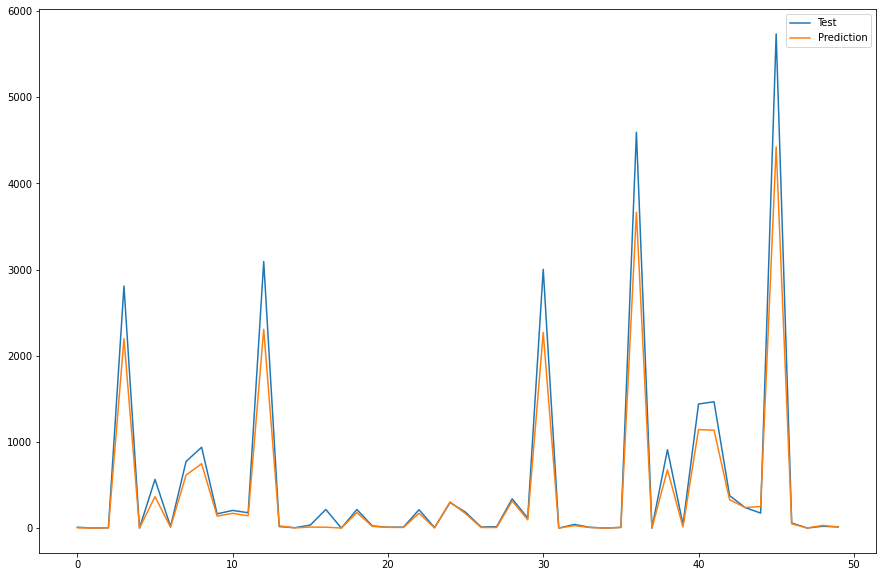

In [30]:
plt.figure(figsize=(15,10))
plt.plot(test_Y.iloc[0,:50], label = 'Test')
plt.plot(Predict.iloc[0,:50], label = 'Prediction')
plt.legend(loc='best')
plt.show()

In [193]:
test = pd.read_csv('test.csv')

In [194]:
test.date = pd.to_datetime(test.date)

In [42]:
tests = pd.read_csv('test.csv')

In [45]:
28512 - 5346

23166

In [46]:
23166/54/33

13.0

In [97]:
7128/1782

4.0

In [87]:
54*33

1782

In [49]:
def make_dataset_t(data):
  datasetX = []
  max_length = len(data)
  for i in range(5346,max_length-54*33+1,54*33):
    datasetX.append(data[i-5346:i,1])

  return datasetX

In [50]:

test = test.sort_values(['date','store_nbr','family'])

test = test.set_index('date').drop(['id','family'],axis = 1).copy()

test = np.array(test)
test = make_dataset_t(test)

test = np.array(test)
test = np.asarray(test).astype(np.float32)
#scaling  # データを0～1の範囲にスケールするための関数。
scaler.fit(test)  # スケーリングに使用する最小／最大値を計算する。
test1 = scaler.transform(test)  # Xをを0～1の範囲にスケーリングする。


test1 = np.reshape(test1,(test1.shape[0],1,test1.shape[1]))
print(test1.shape)

(13, 1, 5346)


In [51]:
test1.shape

(13, 1, 5346)

In [52]:
sub = model.predict(test1)

In [53]:
sub.shape

(13, 1782)

In [44]:
1782*16

28512

In [54]:
sub=pd.DataFrame(sub)

In [55]:
sub = scaler1.inverse_transform(sub)

In [56]:
subm = []
for i in sub:
  for k in i:
    subm.append(k)

subm = pd.DataFrame(subm)
subm

,0
0,3.542697
1,0.007595
2,2.514630
3,2127.798096
4,-0.016754
...,...
23161,50.570942
23162,70.842308
23163,635.682739
23164,-0.025717


In [268]:
hosokumi['id'] = pd.DataFrame(list(range(3000888,3029400)))
hosokumi = hosokumi.set_index(['id'])

In [176]:
submits['id'] = pd.DataFrame(list(range(3000888,3029400)))
submits

,id,0
0,3000888,0.000000
1,3000889,0.000000
2,3000890,0.000000
3,3000891,0.000000
4,3000892,0.000000
...,...,...
28507,3029395,50.570942
28508,3029396,70.842308
28509,3029397,635.682739
28510,3029398,-0.025717


In [175]:
submits = submits.reset_index()

In [177]:
submits = submits.set_index('id')
submits

,0
id,
3000888,0.000000
3000889,0.000000
3000890,0.000000
3000891,0.000000
3000892,0.000000
...,...
3029395,50.570942
3029396,70.842308
3029397,635.682739


In [269]:
hosokumi['sales'] = hosokumi.iloc[:,0].copy()

In [270]:
hosokumi = hosokumi.drop(0,axis = 1)

In [267]:
hosokumi = hosokumi.drop('index',axis = 1)

In [271]:
hosokumi

,sales
id,
3000888,3.291813
3000889,0.006433
3000890,2.256763
3000891,1891.297974
3000892,-0.020490
...,...
3029395,50.570942
3029396,70.842308
3029397,635.682739


In [272]:
hosokumi.to_csv('pred.csv')

In [273]:
!kaggle competitions submit -c store-sales-time-series-forecasting -f pred.csv -m test

100% 739k/739k [00:03<00:00, 235kB/s]
Successfully submitted to Store Sales - Time Series Forecasting

In [168]:
submit = [0 for i in range(54*33*3)]


In [169]:
submit = pd.DataFrame(submit)

In [170]:
submits = submit.append(subm)

In [147]:
len(submits)

28512

In [202]:
spe = traincsv.sort_values(['date','store_nbr','family']).drop(['id','sales'],axis = 1).copy()

In [203]:
spe = spe.iloc[-54*33*3:,:]
spe = spe.drop(['store_nbr','family'],axis = 1)

In [197]:
testdash = test.sort_values(['date','store_nbr','family'])[:54*33*3]

In [206]:
spe = spe.onpromotion.append(testdash.onpromotion)

In [207]:
spe = spe.reset_index()

,index,onpromotion
0,0,0
1,1,0
2,2,0
3,3,5
4,4,0
...,...,...
10687,5209,5
10688,5210,0
10689,5211,2
10690,5212,0


In [210]:
spe = spe.drop('index',axis = 1)

In [214]:
spe = np.array(spe)

array([[0],
       [0],
       [0],
       ...,
       [2],
       [0],
       [0]])

In [227]:
datasetX = []
max_length = len(spe)
for i in range(5346,max_length-54*33+1,54*33):
  datasetX.append(spe[i-5346:i,0])
datasetX

[array([ 0,  0,  0, ..., 76,  0,  0]),
 array([  0,   0,   1, ..., 225,  14,   0]),
 array([0, 0, 1, ..., 0, 0, 0])]

In [228]:
datasetX = np.array(datasetX)

In [229]:
scaler.fit(datasetX)  # スケーリングに使用する最小／最大値を計算する。
datasetX = scaler.transform(datasetX)

In [230]:
datasetX

array([[0.        , 0.        , 0.        , ..., 0.33777778, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 1.        , 1.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ]])

In [231]:
datasetX = np.reshape(datasetX,(3,1,5346))
datasetX.shape

(3, 1, 5346)

In [241]:
hosoku = model.predict(datasetX)

In [242]:
hosoku = pd.DataFrame(hosoku)
hosoku = scaler1.inverse_transform(hosoku)

In [235]:
hosoku = pd.DataFrame(hosoku)
hosoku

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1742,1743,1744,1745,1746,1747,1748,1749,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763,1764,1765,1766,1767,1768,1769,1770,1771,1772,1773,1774,1775,1776,1777,1778,1779,1780,1781
0,3.291813,0.006433,2.256763,1891.297974,-0.020490,352.917328,8.109735,672.464050,667.183655,134.915131,130.642639,130.815002,2124.400146,26.617582,2.075758,17.278696,12.786943,0.311458,169.407410,17.816088,8.705491,6.633869,75.789879,1.699795,279.064911,132.230820,6.445808,5.854989,263.170410,90.744431,2099.423828,0.448723,21.501894,5.067533,-0.007105,5.409494,2891.075928,0.006870,622.746704,7.481361,...,1.241805,4.724975,167.704086,60.372200,1256.579102,0.320666,5.040291,5.636667,0.284479,0.447228,1468.350586,-0.002384,266.856384,4.313044,1179.100586,188.804916,214.289810,91.957863,32.957623,2542.126465,7.895539,0.757069,15.163314,12.366358,0.210631,231.697495,0.000126,0.007856,4.727475,7.091209,0.279758,54.065979,203.623657,0.069017,2.196199,52.458820,73.634392,584.598633,-0.011096,1.695392
1,3.350852,0.007582,2.525075,2025.840088,-0.030328,360.572296,8.186692,690.184937,680.282776,139.500320,131.682739,153.022308,2177.801514,25.905262,2.304564,17.557188,14.544444,0.317608,185.532089,20.084328,8.241467,6.908698,85.092186,1.968877,289.893677,135.107117,7.425411,6.691546,270.043060,95.026253,2368.501709,0.537367,22.300072,4.928636,-0.013533,5.832726,3156.968750,0.011622,615.812927,9.849344,...,1.595955,6.725941,160.711655,61.101238,1660.658813,0.582214,4.698708,5.991417,0.426942,0.376168,1707.697998,-0.002917,245.683121,5.667132,1140.074951,179.843781,201.746643,77.348221,38.853386,2379.853027,8.736036,0.938684,14.468147,16.061335,0.140320,279.028076,-0.000631,0.008885,3.936661,9.237956,0.229369,50.835148,189.199554,0.044004,2.924880,47.567207,71.571495,711.865723,-0.079394,1.638522
2,2.170287,0.006529,1.457928,1209.615356,-0.028583,243.164612,5.449094,482.555969,482.461914,102.481071,91.322006,81.239868,1450.255859,18.125170,1.283337,9.294560,11.115728,0.116011,117.646858,11.442660,8.417603,6.990300,-0.693735,0.861714,246.645294,95.332069,4.859291,2.877232,234.571136,66.046951,1584.863770,0.287433,17.391504,5.340162,-0.004468,6.402088,2977.773926,0.009165,707.503418,3.818141,...,1.175276,4.724098,201.257370,74.584511,1225.055908,0.586805,6.014037,7.006148,0.233230,0.596629,1646.059814,-0.000559,342.225433,2.574405,1532.500732,254.092255,273.012421,120.511513,19.469883,3192.881836,8.720093,0.709376,14.678885,13.471319,0.167643,253.705200,0.003577,0.006533,5.614351,-16.472145,0.097561,62.971085,247.230301,0.064483,1.678731,57.547543,94.370758,567.428650,-0.005076,1.841762


In [244]:
hosokum = []
for i in hosoku:
    for k in i:
      hosokum.append(k)


In [263]:
hosokumi = pd.DataFrame(hosokum)

In [264]:
hosokumi = hosokumi.append(subm)

In [265]:
hosokumi = hosokumi.reset_index()

In [266]:
hosokumi


,index,0
0,0,3.291813
1,1,0.006433
2,2,2.256763
3,3,1891.297974
4,4,-0.020490
...,...,...
28507,23161,50.570942
28508,23162,70.842308
28509,23163,635.682739
28510,23164,-0.025717
